# Deep Convolutional Generative Adversarial Networks
The goal of GANs is to train a generator network $G(z)$ to capture the data distribution of the training dataset so as to 
generate fake samples from the data distribution, $P_{data}(x)$, by transforming vectors of noise $z$ as $\acute x=P_{model}(x) = G(z)$


GANs are deep neural networks architectures made up of two networks a generator network $G$ and a discriminator network $D$ which are simultaneously trained and arranged in competition with each other. The Generator $G$ is trained to capture the distribution of the training samples (real data) $P_{data}$ so as to generate fake samples that follow the distribution of the real samples which are indistinguishable from the real data (training) with the aim to minimize the probability of the discriminator to corrrectly distinguish fake data from the real ones. The discriminator is trained to maximize it probability of correctly assigning real label to real training samples and the fake label to the generated samples from  $G$.

The discriminator is a binary classifier to distinguish between real data assumd to have label $y=1$ and a
fake data $y=0$.


For $G$ to generate fake samples, the inputs $z$ to $G$ are randomly sampled from the model’s prior over the latent variables. It then applies the generator network $G$ to generate $\acute x=G(z)$. The goal of the generator is to fool the discriminator by generating fake samples which are indistinguishable from the real data (training) by making $D$ detect that $D(G(z)) \approx 1( real \ data)$

The discriminator strives to make $D(G(z)) \approx 0$ while the generative strives to make $D(G(z)) \approx 1$


**Training objective of GANs**

The discriminator is a binary classifier trained to distinguish between real data $x$ assumd to have lable $y=1$ and a
fake data $\acute x$ (from the generator) with lable $y=0$.The discriminator  is trained to minimize the binary cross-entropy loss

$$ min_{D} \{ -ylog D(x)-(1-y)log(1-D(x) \} $$ 


For $G$ to generate fake samples, the inputs $z$ are randomly sampled from the model’s prior over the latent variables. It then applies the generator network $G$ to generate $\acute x=G(z)$. The goal of the generator is to fool the discriminator by generating fake samples which are indistinguishable from the real data (training) by making $D$ detect that $D(G(z)) \approx 1( real \ data)$


The generator $G$ is trained to maximize the cross-entropy loss when $y = 0$
$$ max_{G}\{- (1-y)log(1-D(G(Z))\}=max_{G}\{-log(1-D(G(z)) \} $$

If $G$ is generating fake samples which are indistinguishable from the real data, then $D(G(z)) ≈ 1$ leading to the above loss near 0. This results in the gradients being too small which affect the training of the  discriminator since the generator through it loss function does not provide enough gradient information to the discriminator to update it parameters.
 So commonly we minimize the following loss:
 
 $$ min_{G}\{-ylogD(G(Z))\}=max_{G}\{-log D(G(z)) \} $$
 
which is just feed x′ = G(z) into the discriminator but giving label y = 1 

we Jointly train generator G and discriminator D with a minimax game


 $$ min_{D}max_{G} V(D,G)=-\left[ E_{x \sim P_{data}} log D(x)  + E_{z \sim p(z)} log (1-D(G(z)) \right] $$
   

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras as K
from keras.datasets import fashion_mnist

In [2]:
tf.random.set_seed(1000)
np.random.seed(1000)
plt.rcParams['image.cmap']='gray'
K.__version__,tf.__version__

('2.8.0', '2.8.0')

In [3]:
(x_train,y_train),(x_test,y_test)=fashion_mnist.load_data()
x_train=x_train.astype(np.float32)/255.0
x_test=x_test.astype(np.float32)/255.0
x_train=x_train.reshape(60000, 28, 28,1)
x_test=x_test.reshape(10000, 28, 28,1)
x_train.shape,x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [4]:
np.max(x_train[1]),np.min(x_train[1])

(1.0, 0.0)

In [5]:
latent_dim=100
buffer_size=len(x_train)
batch_size=100
x_train_d=tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size).batch(batch_size)

In [6]:
K.backend.clear_session()
init_w=K.initializers.RandomNormal(mean=0,stddev=0.2)

In [7]:
discriminator=K.models.Sequential([
                     K.layers.InputLayer(input_shape=(28,28,1)),
    
                     K.layers.Conv2D(64,kernel_size=4,strides=2,padding='same'),
                     K.layers.LeakyReLU(alpha=0.2),
    
                     K.layers.Conv2D(100,kernel_size=4,strides=2,padding='same'),
                     K.layers.BatchNormalization(),
                     K.layers.LeakyReLU(alpha=0.2),
    
                     K.layers.Flatten(),
                     K.layers.Dropout(0.2),
                     K.layers.Dense(1,activation='sigmoid')
                                   ],name='discriminator')


In [8]:
generator =K.Sequential( [
        K.Input(shape=(latent_dim,)),
        K.layers.Dense(8*8*100,use_bias=False),
        K.layers.ReLU(),
        K.layers.Reshape((8, 8, 100)),
        K.layers.UpSampling2D(),
    
        K.layers.Conv2D(64, kernel_size=4, padding="same",kernel_initializer=init_w,use_bias=False ),
        K.layers.BatchNormalization(),
        K.layers.ReLU(),
        K.layers.Conv2DTranspose(128, kernel_size=4, strides=1, padding="same",use_bias=False ),
        K.layers.ReLU(),
        
        K.layers.Conv2D(128, kernel_size=4,  padding="same",use_bias=False ),
        K.layers.BatchNormalization(),
        K.layers.ReLU(),
       
        K.layers.UpSampling2D(),
    
        K.layers.Conv2D(1, kernel_size=5, activation="tanh",use_bias=False)
                          ],'generator')

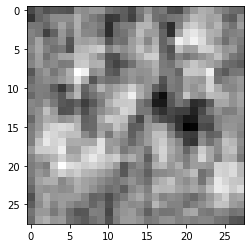

In [9]:
noise=tf.random.normal((1,latent_dim))
gen=generator(noise,training=False  )
d=tf.reshape(gen,(28,28))
plt.imshow(d)

In [10]:
output=discriminator(gen)
output

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.5098337]], dtype=float32)>

![](./images/gan.svg)
source [Generative Adversarial Networks](http://d2l.ai/chapter_generative-adversarial-networks/gan.html)

In [11]:
class GAN(K.Model):
    def __init__(self,discriminator,generator,latent_dim):
        super(GAN,self).__init__()
        self.discriminator=discriminator
        self.generator=generator
        self.latent_dim=latent_dim
        self.d_loss_metric=K.metrics.Mean(name='d_loss')
        self.g_loss_metric=K.metrics.Mean(name='g_loss')
        self.bce=tf.keras.losses.BinaryCrossentropy( from_logits=True)
    
    def discriminator_loss(self,real_output,fake_output):
        
        real_loss=self.bce(tf.ones_like((real_output,)),real_output)
        fake_loss=self.bce(tf.zeros_like((fake_output,)),fake_output) 
        total_loss=real_loss+fake_loss
        return total_loss
    
    def generator_loss(self,fake_output):
        fake_output_ones=tf.ones_like((fake_output,))
        fake_loss=self.bce(fake_output_ones,fake_output)
        return fake_loss
        
    def compile(self,g_optimizer,d_optimizer):
        super(GAN,self).compile()
        self.g_optimizer=g_optimizer
        self.d_optimizer=d_optimizer
        
    @property
    def metrics(self):
        return [self.d_loss_metric,self.g_loss_metric]
    
    def train_step(self,real_data):
        batch_size=tf.shape(real_data)[0]
        z_random_latent_vectors=tf.random.normal(shape=(batch_size,self.latent_dim))
        with tf.GradientTape() as tape:
            fake_outputs=self.discriminator(self.generator(z_random_latent_vectors))
            real_outputs=self.discriminator(real_data)
            dis_loss=self.discriminator_loss(real_outputs,fake_outputs)
        grads=tape.gradient(dis_loss,self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads,self.discriminator.trainable_weights))  
        
        
        z_random_latent_vectors=tf.random.normal(shape=(batch_size,self.latent_dim))
        with tf.GradientTape() as tape:
            fake_outputs=self.discriminator(self.generator(z_random_latent_vectors))
            gen_loss=self.generator_loss(fake_outputs)
        grads=tape.gradient(gen_loss,self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads,self.generator.trainable_weights))
    
        self.d_loss_metric.update_state(dis_loss)
        self.g_loss_metric.update_state(gen_loss)
        return {'d_loss':self.d_loss_metric.result(),"g_loss":self.g_loss_metric.result()}
           

In [12]:
K.backend.clear_session()

In [13]:
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(d_optimizer=K.optimizers.Adam(1e-4 ), g_optimizer=K.optimizers.Adam(1e-4))

In [14]:
gan.generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6400)              640000    
                                                                 
 re_lu (ReLU)                (None, 6400)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 100)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 16, 16, 100)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        102400    
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                         

In [ ]:
gan.fit(x_train_d,epochs=100,batch_size=200)

In [15]:
gan.fit(x_train_d,epochs=100,batch_size=200)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


600/600 [==============================] - 66s 101ms/step - d_loss: 0.8653 - g_loss: 3.3438
Epoch 2/100
600/600 [==============================] - 60s 100ms/step - d_loss: 1.3492 - g_loss: 0.7197
Epoch 3/100
600/600 [==============================] - 59s 99ms/step - d_loss: 1.3431 - g_loss: 0.7510
Epoch 4/100
600/600 [==============================] - 59s 99ms/step - d_loss: 1.3114 - g_loss: 0.7929
Epoch 5/100
600/600 [==============================] - 59s 98ms/step - d_loss: 1.2672 - g_loss: 0.8292
Epoch 6/100
600/600 [==============================] - 59s 98ms/step - d_loss: 1.2405 - g_loss: 0.9397
Epoch 7/100
600/600 [==============================] - 59s 98ms/step - d_loss: 1.2702 - g_loss: 0.8005
Epoch 8/100
600/600 [==============================] - 60s 99ms/step - d_loss: 1.1248 - g_loss: 1.0579
Epoch 9/100
600/600 [==============================] - 59s 98ms/step - d_loss: 1.2151 - g_loss: 0.8913
Epoch 10/100
600/600 [==============================] - 59s 99ms/step - d_loss: 1.0

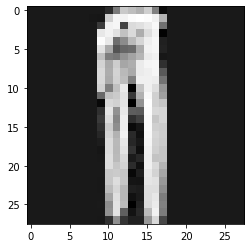

In [16]:
noise=tf.random.normal((1,latent_dim))
gen=gan.generator.predict(noise)
gen=tf.reshape(gen,(28,28))
plt.imshow(gen)

In [17]:
noise=tf.random.normal((10,latent_dim))
imgs=gan.generator.predict(noise)


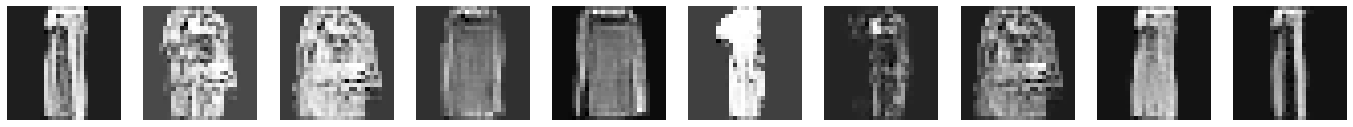

In [19]:
n=10
plt.figure(figsize=(24,10))
for i in range(n):
  bx=plt.subplot(2,10,i+n+1)
  plt.imshow(tf.squeeze(imgs[i]))
  plt.axis('off')

  **REFERENCE**

- [Generative Adversarial Networks](http://d2l.ai/chapter_generative-adversarial-networks/gan.html)

- [Generative Adversarial Nets](https://arxiv.org/pdf/1406.2661.pdf)

- [NIPS 2016 Tutorial: Generative Adversarial Networks](https://arxiv.org/pdf/1701.00160.pdf)